# Introduction

Since Jan. 1, 2015, [The Washington Post](https://www.washingtonpost.com/) has maintained **Fatal Force**, a comprehensive record of every on-duty police shooting in the United States. The database now includes over **10,400** incidents, each with attributes such as:

- **Race**, **age**, and **gender** of the victim  
- Whether the victim was **armed**  
- Whether a **mental-health crisis** was involved  
- The **law enforcement agency**  

<center><img src=https://i.imgur.com/sX3K62b.png></center>  

<figcaption><small>Figure 1. Monthly counts of civilians shot and killed by on-duty U.S. police officers (Jan 2015–Dec 2024).</small></figcaption>  

In this notebook, we focus on building a **Data Warehouse (DW)** around Fatal Force. Using **SQL workflows**, we:  

1. **Stage** the raw incident and Census files into structured tables  
2. **Clean & normalize** fields (city, state, FIPS GEOID) for consistency  
3. **Integrate** four Census-derived indicators from the **2023 5-year American Community Survey (ACS)**:  
   - Median Household Income (`B19013_001E`)  
   - Poverty Rate (`B17001_002E` / `B17001_001E`)  
   - High-School Completion (`B15003_017E–025E` / `B15003_001E`)  
   - Racial Composition (`B02001_00xE`)  
4. **Transform** the data into fact and dimension tables for efficient querying  
5. **Analyze** patterns by linking police-involved fatalities with community-level socioeconomic indicators  

This warehouse approach ensures a **clean, query-ready foundation** for downstream EDA, visualization, and machine learning.  

**Census Data Source:** [data.census.gov](https://data.census.gov/)  


##  Data Staging

We load raw CSV files into **SQLite** as a staging step, creating a consistent and accessible source of truth before cleaning and transformation.  

**Why it matters:**  
- Preserves raw data for reference  
- Simplifies SQL queries by centralizing datasets  
- Sets the foundation for the upcoming Data Cleaning (T1) step  

**Steps:** Extract → Load → Verify  


##  Setup & Data Loading

To prepare the environment and stage raw data:  

1. **Import & Configure**  
   - Reload `ipython-sql` for running SQL in Jupyter  
   - Silence warnings and set output display styles  
   - Connect SQLite (`sql_project.db`) with Pandas + SQLAlchemy integration  

2. **Load Data into SQLite**  
   - Create/Connect to `sql_project.db`  
   - Load the DataFrame into `city_facts` (replace if exists)  
   - Confirm successful load (32,325 rows in this case)  

With this setup, the raw data is centralized in SQLite, providing a clean foundation for Data Cleaning and Transformation.



## Import Statements

In [17]:
# If you're in a fresh environment, uncomment to install:
# !pip install sqlalchemy ipython-sql pandas

# Reload/load the ipython-sql extension
%reload_ext sql

# Silence prettytable deprecation warnings
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning, module="prettytable")

# Configure ipython-sql output (string style names only)
%config SqlMagic.style = 'MARKDOWN'   # or 'PLAIN_COLUMNS' if you prefer
%config SqlMagic.autopandas = True
%config SqlMagic.feedback = False

# Connect to your local SQLite database (creates the file if needed)
%sql sqlite:///sql_project.db

# Also create a SQLAlchemy engine for Pandas <-> SQLite I/O
import pandas as pd
from sqlalchemy import create_engine
engine = create_engine("sqlite:///sql_project.db")

print("✅ Connected to sql_project.db")





✅ Connected to sql_project.db


In [18]:
from sqlalchemy import create_engine

# Create/connect SQLite database
engine = create_engine("sqlite:///sql_project.db")

# Table name
TABLE_NAME = "city_facts"

# Load DataFrame into SQLite (replace if exists)
df.to_sql(TABLE_NAME, con=engine, if_exists="replace", index=False)

print(f"✅ Loaded {len(df):,} rows into '{TABLE_NAME}' table in sql_project.db")


✅ Loaded 32,325 rows into 'city_facts' table in sql_project.db


In [19]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)


In [20]:
import prettytable as pt

# Only assign if missing (keeps compat, no repeated warnings)
if not hasattr(pt, "DEFAULT"):
    pt.DEFAULT = pt.TableStyle.DEFAULT
if not hasattr(pt, "MSWORD_FRIENDLY"):
    pt.MSWORD_FRIENDLY = pt.TableStyle.MSWORD_FRIENDLY
if not hasattr(pt, "PLAIN_COLUMNS"):
    pt.PLAIN_COLUMNS = pt.TableStyle.PLAIN_COLUMNS
if not hasattr(pt, "SINGLE_BORDER"):
    pt.SINGLE_BORDER = pt.TableStyle.SINGLE_BORDER
if not hasattr(pt, "DOUBLE_BORDER"):
    pt.DOUBLE_BORDER = pt.TableStyle.DOUBLE_BORDER
if not hasattr(pt, "MARKDOWN"):
    pt.MARKDOWN = pt.TableStyle.MARKDOWN

# Reload and set sql style
%reload_ext sql
%config SqlMagic.style = 'PLAIN_COLUMNS'
%sql sqlite:///sql_project.db



## Data Cleaning (T1) — Create Clean View

To prepare the dataset for analysis, we:  

- **Drop old view** if it exists  
- **Create a new view** `city_facts_clean` with consistent column names  
- **Rename fields** (e.g., `"Median Income"` → `median_income`, `"share_two+"` → `share_two_plus`)  
- **Select only relevant columns** including demographics, income, education, and fatality counts  

This step ensures the data is standardized, easy to query, and ready for downstream analysis.


In [25]:

%%sql
DROP VIEW IF EXISTS city_facts_clean;

CREATE VIEW city_facts_clean AS
SELECT
  state,
  city,
  "Median Income"              AS median_income,
  poverty_rate,
  percent_completed_hs,
  share_white,
  share_black,
  share_native,
  share_asian,
  share_pacisl,
  share_other,
  "share_two+"                 AS share_two_plus,
  total_fatalities_2015_24     AS total_fatalities,
  income_log,
  pct_nonwhite,
  poverty_quintile
FROM city_facts;


 * sqlite:///sql_project.db


Empty DataFrame
Columns: []
Index: []

##  State-Level Summary (T2)

To optimize queries and aggregate data by state:

1. **Indexes Created**  
   - `state`, `city`, and `poverty_quintile` indexed in `city_facts`  
   - Improves performance of grouping and filtering operations  

2. **Create View: `state_summary`**  
   - Aggregates city-level facts into state-level metrics  
   - Calculates:  
     - Number of cities (`cities`)  
     - Total fatalities (`total_fatalities`)  
     - Average income, poverty rate, HS completion, % nonwhite  
     - Fatalities per city (normalized measure)  

This step provides a **state-level lens** for comparing socioeconomic indicators and police-involved fatalities.


In [26]:
from sqlalchemy import create_engine
engine = create_engine("sqlite:///sql_project.db")
with engine.begin() as conn:
    conn.exec_driver_sql("CREATE INDEX IF NOT EXISTS idx_cf_state ON city_facts(state);")
    conn.exec_driver_sql("CREATE INDEX IF NOT EXISTS idx_cf_city ON city_facts(city);")
    conn.exec_driver_sql("CREATE INDEX IF NOT EXISTS idx_cf_povq ON city_facts(poverty_quintile);")
print("✅ Indexes ready (state, city, poverty_quintile)")


✅ Indexes ready (state, city, poverty_quintile)


##  State Summary View (T3)

We aggregate city-level data into **state-level metrics** for easier comparison:

- **Cities**: total number of cities per state  
- **Fatalities**: sum of total police-involved fatalities  
- **Avg Income**: mean household income  
- **Avg Poverty Rate**: mean poverty rate (%)  
- **Avg HS Completion**: mean % of high-school completion  
- **Avg % Nonwhite**: mean percentage of nonwhite residents  
- **Fatalities per City**: normalized fatalities (total ÷ cities)  

This summary view (`state_summary`) provides a high-level lens to compare **socioeconomic indicators vs. fatalities** across U.S. states.


In [27]:
%%sql
DROP VIEW IF EXISTS state_summary;
CREATE VIEW state_summary AS
SELECT
  state,
  COUNT(*)                                        AS cities,
  SUM(COALESCE(total_fatalities,0))              AS total_fatalities,
  ROUND(AVG(median_income),2)                     AS avg_income,
  ROUND(AVG(poverty_rate),2)                      AS avg_poverty_rate,
  ROUND(AVG(percent_completed_hs),2)              AS avg_hs_completion,
  ROUND(AVG(pct_nonwhite),2)                      AS avg_pct_nonwhite,
  ROUND(1.0*SUM(COALESCE(total_fatalities,0))/COUNT(*),3) AS fatalities_per_city
FROM city_facts_clean
GROUP BY state;


 * sqlite:///sql_project.db


Empty DataFrame
Columns: []
Index: []

##  Poverty Quintile Summary (T4)

We group cities by **poverty quintile** to study how socioeconomic disadvantage relates to fatality rates.  

Metrics computed for each quintile:  
- **Cities**: number of cities in the group  
- **Total Fatalities**: sum of police-involved fatalities  
- **Avg Income**: mean household income  
- **Avg Poverty Rate**: mean poverty rate (%)  
- **Avg HS Completion**: mean % high-school completion  
- **Avg % Nonwhite**: mean percentage of nonwhite residents  
- **Fatalities per City**: normalized fatalities (total ÷ cities)  

This summary (`poverty_quintile_summary`) highlights how police-involved fatalities vary **across levels of community poverty**.


In [28]:
%%sql
DROP VIEW IF EXISTS poverty_quintile_summary;
CREATE VIEW poverty_quintile_summary AS
SELECT
  poverty_quintile,
  COUNT(*)                                        AS cities,
  SUM(COALESCE(total_fatalities,0))              AS total_fatalities,
  ROUND(AVG(median_income),0)                     AS avg_income,
  ROUND(AVG(poverty_rate),2)                      AS avg_poverty_rate,
  ROUND(AVG(percent_completed_hs),2)              AS avg_hs_completion,
  ROUND(AVG(pct_nonwhite),2)                      AS avg_pct_nonwhite,
  ROUND(1.0*SUM(COALESCE(total_fatalities,0))/COUNT(*),3) AS fatalities_per_city
FROM city_facts_clean
GROUP BY poverty_quintile
ORDER BY poverty_quintile;


 * sqlite:///sql_project.db


Empty DataFrame
Columns: []
Index: []

##  Race Profile by State (T5)

We group cities by **state** to compute average racial composition alongside fatalities.  

Metrics included:  
- **Avg White, Black, Native, Asian, Pacific Islander, Other, Two+** (% shares)  
- **Total Fatalities** per state  

This `race_profile_by_state` view provides a demographic context for analyzing how **racial composition** relates to police-involved fatalities.


In [29]:
%%sql
DROP VIEW IF EXISTS race_profile_by_state;
CREATE VIEW race_profile_by_state AS
SELECT
  state,
  ROUND(AVG(share_white),2)     AS avg_white,
  ROUND(AVG(share_black),2)     AS avg_black,
  ROUND(AVG(share_native),2)    AS avg_native,
  ROUND(AVG(share_asian),2)     AS avg_asian,
  ROUND(AVG(share_pacisl),2)    AS avg_pacisl,
  ROUND(AVG(share_other),2)     AS avg_other,
  ROUND(AVG(share_two_plus),2)  AS avg_two_plus,
  SUM(COALESCE(total_fatalities,0)) AS total_fatalities
FROM city_facts_clean
GROUP BY state;


 * sqlite:///sql_project.db


Empty DataFrame
Columns: []
Index: []

##  Analysis (A1) — Top 10 States by Fatalities

Querying the `state_summary` view to identify states with the **highest total fatalities**:  

- Shows `state`, `total_fatalities`, number of `cities`, and `fatalities_per_city`  
- Includes socioeconomic context (`avg_income`, `avg_poverty_rate`)  
- Results are ordered by `total_fatalities` (descending)  
- Limited to **Top 10 states**  

This provides an initial **ranking of states** most affected by police-involved fatalities, setting the stage for deeper comparisons.


In [30]:
%%sql
SELECT state, total_fatalities, cities, fatalities_per_city, avg_income, avg_poverty_rate
FROM state_summary
ORDER BY total_fatalities DESC
LIMIT 10;


 * sqlite:///sql_project.db


state  total_fatalities  cities  fatalities_per_city  avg_income  \
0    NV                 5     133                0.038    80514.44   
1    IA                 1    1026                0.001    67713.88   
2    NJ                 1     700                0.001   115107.34   
3    PA                 1    2002                0.000    72901.65   
4    UT                 1     334                0.003    88414.41   
5    AK                 0     355                0.000    66786.70   
6    AL                 0     593                0.000    57494.78   
7    AR                 0     625                0.000    51470.37   
8    AZ                 0     467                0.000    60683.02   
9    CA                 0    1618                0.000    96269.86   

   avg_poverty_rate  
0             12.00  
1             10.81  
2              7.58  
3             11.90  
4              9.90  
5             17.37  
6             17.77  
7             19.31  
8             20.87  
9             13.64

##  Analysis (A2) — Poverty Quintile Summary

Querying the `poverty_quintile_summary` view to explore how fatalities vary across socioeconomic tiers:  

- Groups cities into **5 poverty quintiles** (from wealthiest → poorest)  
- Displays summary statistics:  
  - `cities` (count per quintile)  
  - `total_fatalities`  
  - `avg_income`, `avg_poverty_rate`, `avg_hs_completion`, `avg_pct_nonwhite`  
  - `fatalities_per_city` (normalized rate)  

This provides insight into whether **higher-poverty communities** face disproportionate rates of police-involved fatalities.


In [31]:
%%sql
SELECT * FROM poverty_quintile_summary;


 * sqlite:///sql_project.db


poverty_quintile  cities  total_fatalities  avg_income  avg_poverty_rate  \
0                 1    6477                 0     99887.0              1.57   
1                 2    6573                 3     88046.0              6.51   
2                 3    6423                 5     70599.0             11.25   
3                 4    6419                 1     58143.0             17.52   
4                 5    6433                 0     46974.0             36.25   

   avg_hs_completion  avg_pct_nonwhite  fatalities_per_city  
0              92.72             15.72                0.000  
1              92.52             18.69                0.000  
2              89.89             21.17                0.001  
3              87.14             24.24                0.000  
4              81.37             36.13                0.000

## Analysis (A3) — States by Racial Composition

We query the `state_summary` view to rank states based on **average % nonwhite population**:  

1. **Top 10 states (highest % nonwhite)**  
2. **Bottom 10 states (lowest % nonwhite)**  

For each state, we display:  
- `avg_pct_nonwhite` (racial composition)  
- `total_fatalities` (police-involved deaths)  

This comparison highlights whether states with higher or lower racial diversity show different patterns of police-involved fatalities.


In [32]:
%%sql
SELECT state, avg_pct_nonwhite, total_fatalities
FROM state_summary
ORDER BY avg_pct_nonwhite DESC
LIMIT 10;

SELECT state, avg_pct_nonwhite, total_fatalities
FROM state_summary
ORDER BY avg_pct_nonwhite ASC
LIMIT 10;


 * sqlite:///sql_project.db


state  avg_pct_nonwhite  total_fatalities
0    ME              7.24                 0
1    NH              7.44                 0
2    IA              7.61                 1
3    WV              7.97                 0
4    VT              8.15                 0
5    IN              8.94                 0
6    NE              9.52                 0
7    PA             11.33                 1
8    WI             11.33                 0
9    OH             11.34                 0

## Analysis (A4) — Correlation: Income vs. Fatalities

We compute the **Pearson correlation coefficient** between:  
- `median_income` (x)  
- `total_fatalities` (y)  

Steps:  
1. Cast both fields as numeric values  
2. Filter out NULLs  
3. Apply the correlation formula using averages and square roots  

**Result (`corr_income_vs_fatalities`)**: ~0.0026 → indicates **almost no correlation** between city-level income and police-involved fatalities.  

This suggests that **median income alone** is not a strong predictor of fatality counts.


In [33]:
%%sql
WITH base AS (
  SELECT 
    CAST(median_income AS REAL) AS x,
    CAST(total_fatalities AS REAL) AS y
  FROM city_facts_clean
  WHERE median_income IS NOT NULL AND total_fatalities IS NOT NULL
)
SELECT 
  (AVG(x*y) - AVG(x)*AVG(y)) /
  (SQRT(AVG(x*x) - AVG(x)*AVG(x)) * SQRT(AVG(y*y) - AVG(y)*AVG(y))) AS corr_income_vs_fatalities
FROM base;


 * sqlite:///sql_project.db


corr_income_vs_fatalities
0                   0.002615

## Validation (V1) — Missing Data Check

Before further analysis, we verify data completeness in `city_facts`:  

- **Total Rows**: 32,325  
- **Missing State/City**: 0  
- **Missing Median Income**: 0  

This confirms that the dataset is **clean and complete** for these key fields, ensuring reliability of subsequent transformations and analysis.


In [34]:
%%sql
SELECT 
  COUNT(*) AS rows,
  SUM(CASE WHEN state IS NULL OR city IS NULL THEN 1 ELSE 0 END) AS missing_state_city,
  SUM(CASE WHEN "Median Income" IS NULL THEN 1 ELSE 0 END) AS missing_income
FROM city_facts;


 * sqlite:///sql_project.db


rows  missing_state_city  missing_income
0  32325                   0               0

##  Validation (V2) — Duplicate City Check

We verify whether any cities appear multiple times in `city_facts`:  

- Query groups by `(state, city)` and counts rows  
- Flags cases where `n > 1` as duplicates  
- **Result**: `0` duplicate rows found  

This confirms that each **city–state pair** is uniquely represented in the dataset, avoiding double-counting in later aggregations.


In [35]:
%%sql
WITH d AS (
  SELECT state, city, COUNT(*) AS n
  FROM city_facts
  GROUP BY 1,2
)
SELECT SUM(CASE WHEN n>1 THEN 1 ELSE 0 END) AS dup_city_rows
FROM d;


 * sqlite:///sql_project.db


dup_city_rows
0              0

##  Validation (V3) — Racial Composition Integrity

We verify that racial share percentages (`share_white`, `share_black`, `share_asian`, etc.) fall within a valid **0–100% range**.  

- Any negative values or values above 100 are flagged as errors  
- **Result**: No invalid values detected across all race categories  

This confirms that the racial composition data is **valid and consistent**, ensuring reliable demographic analysis.


In [36]:
%%sql
SELECT 
  SUM(CASE WHEN share_white  < 0 OR share_white  > 100 THEN 1 ELSE 0 END) AS bad_white,
  SUM(CASE WHEN share_black  < 0 OR share_black  > 100 THEN 1 ELSE 0 END) AS bad_black,
  SUM(CASE WHEN share_native < 0 OR share_native > 100 THEN 1 ELSE 0 END) AS bad_native,
  SUM(CASE WHEN share_asian  < 0 OR share_asian  > 100 THEN 1 ELSE 0 END) AS bad_asian,
  SUM(CASE WHEN share_pacisl < 0 OR share_pacisl > 100 THEN 1 ELSE 0 END) AS bad_pacisl,
  SUM(CASE WHEN share_other  < 0 OR share_other  > 100 THEN 1 ELSE 0 END) AS bad_other,
  SUM(CASE WHEN "share_two+"< 0 OR "share_two+"> 100 THEN 1 ELSE 0 END) AS bad_two_plus
FROM city_facts;


 * sqlite:///sql_project.db


bad_white  bad_black  bad_native  bad_asian  bad_pacisl  bad_other  \
0          0          0           0          0           0          0   

   bad_two_plus  
0             0

## Validation (V4) — Racial Composition Totals

We validate that the sum of all racial shares (`white + black + native + asian + pacisl + other + two_plus`) is approximately **100%** for each city:  

- Allowance: ±1.0 tolerance (to handle rounding/estimation noise)  
- **Result**: `0` rows flagged → all city-level race percentages sum correctly  

This confirms that racial composition distributions are **complete and consistent** across the dataset.


In [37]:
%%sql
-- rows where race shares don't sum to ~100 (+/- 1.0 tolerance)
SELECT COUNT(*) AS off_sum_rows
FROM city_facts
WHERE ABS(
  COALESCE(share_white,0)+COALESCE(share_black,0)+COALESCE(share_native,0)+
  COALESCE(share_asian,0)+COALESCE(share_pacisl,0)+COALESCE(share_other,0)+
  COALESCE("share_two+",0) - 100
) > 1.0;


 * sqlite:///sql_project.db


off_sum_rows
0             0

##  Analysis (A5) — Income Distribution & Poverty Quintile Fatalities

1. **Income Distribution Check**  
   - `min_income`: lowest city-level median income  
   - `max_income`: highest city-level median income  
   - `avg_income`: overall mean  

2. **Poverty Quintile Summary**  
   - Groups cities by `poverty_quintile`  
   - Reports number of cities and **average fatalities** in each group  

This analysis connects **income variation** with **fatality trends** across poverty quintiles, offering insight into whether socioeconomic disadvantage correlates with higher risk.


In [38]:
%%sql
SELECT 
  MIN("Median Income") AS min_income,
  MAX("Median Income") AS max_income,
  AVG("Median Income") AS avg_income
FROM city_facts;

SELECT poverty_quintile, COUNT(*) AS cities, 
       ROUND(AVG(total_fatalities_2015_24),2) AS avg_fatalities
FROM city_facts
GROUP BY 1
ORDER BY 1;


 * sqlite:///sql_project.db


poverty_quintile  cities  avg_fatalities
0                 1    6477             0.0
1                 2    6573             0.0
2                 3    6423             0.0
3                 4    6419             0.0
4                 5    6433             0.0

##  Performance — Targeted Indexing (T2b)

Create indexes on high-traffic columns in `city_facts` to speed up filters, joins, and aggregations:
- `idx_cf_income` on `"Median Income"`
- `idx_cf_fatalities` on `total_fatalities_2015_24`

These accelerate queries used in summaries, correlations, and quintile analyses.




In [39]:
%%sql
CREATE INDEX IF NOT EXISTS idx_cf_income ON city_facts("Median Income");
CREATE INDEX IF NOT EXISTS idx_cf_fatalities ON city_facts(total_fatalities_2015_24);


 * sqlite:///sql_project.db


Empty DataFrame
Columns: []
Index: []

##  Validation (V5) — Duplicate City–State Pairs

We check whether any `(state, city)` combinations appear more than once in `city_facts`:  

- Query groups by `state` + `city` and counts rows  
- Flags cases where `COUNT(*) > 1`  
- **Result**: No duplicates detected ✅  

This ensures that each city–state pair is **uniquely represented**, preventing bias in aggregated results.


In [41]:

%%sql
-- Count rows in each table
SELECT 'raw_deaths' AS table_name, COUNT(*) AS row_count FROM raw_deaths
UNION ALL
SELECT 'raw_income', COUNT(*) FROM raw_income
UNION ALL
SELECT 'raw_poverty', COUNT(*) FROM raw_poverty
UNION ALL
SELECT 'raw_hs', COUNT(*) FROM raw_hs
UNION ALL
SELECT 'raw_race', COUNT(*) FROM raw_race
UNION ALL
SELECT 'city_facts', COUNT(*) FROM city_facts;


 * sqlite:///sql_project.db


table_name  row_count
0   raw_deaths      10430
1   raw_income      32325
2  raw_poverty      32325
3       raw_hs      32325
4     raw_race      32325
5   city_facts      32325

## Validation (V5 & V6) — Data Consistency Checks

1. **Duplicate Check (V5):**  
   - Ensure each `(state, city)` pair is unique in `city_facts`  
   - No duplicates found ✅  

2. **Missing Values Check (V6):**  
   - Counted `NULL`s across all columns  
   - All counts = 0 → dataset is complete with no missing values ✅  

These checks confirm that `city_facts` is both **uniquely keyed** and **fully populated**, ready for analysis.


In [42]:
%%sql
-- Any duplicate city+state combinations in city_facts?
SELECT state, city, COUNT(*) AS dup_count
FROM city_facts
GROUP BY state, city
HAVING COUNT(*) > 1;


 * sqlite:///sql_project.db


Empty DataFrame
Columns: []
Index: []

In [48]:
%%sql
-- Count NULLs for each column in city_facts
SELECT
    SUM(CASE WHEN "Median Income" IS NULL THEN 1 ELSE 0 END) AS missing_income,
    SUM(CASE WHEN poverty_rate IS NULL THEN 1 ELSE 0 END) AS missing_poverty,
    SUM(CASE WHEN percent_completed_hs IS NULL THEN 1 ELSE 0 END) AS missing_hs,
    SUM(CASE WHEN share_white IS NULL THEN 1 ELSE 0 END) AS missing_white,
    SUM(CASE WHEN share_black IS NULL THEN 1 ELSE 0 END) AS missing_black,
    SUM(CASE WHEN share_native IS NULL THEN 1 ELSE 0 END) AS missing_native,
    SUM(CASE WHEN share_asian IS NULL THEN 1 ELSE 0 END) AS missing_asian,
    SUM(CASE WHEN share_pacisl IS NULL THEN 1 ELSE 0 END) AS missing_pacisl,
    SUM(CASE WHEN share_other IS NULL THEN 1 ELSE 0 END) AS missing_other,
    SUM(CASE WHEN "share_two+" IS NULL THEN 1 ELSE 0 END) AS missing_two_plus
FROM city_facts;



 * sqlite:///sql_project.db


missing_income  missing_poverty  missing_hs  missing_white  missing_black  \
0               0                0           0              0              0   

   missing_native  missing_asian  missing_pacisl  missing_other  \
0               0              0               0              0   

   missing_two_plus  
0                 0

## Validation (V7) — Race Share Totals

- Summed all race percentages (`white + black + native + asian + pacisl + other + two+`)  
- Each `(state, city)` row rounds to **100%** → confirms no missing or double-counted groups  
- Sample below shows AK cities all = 100.0  
- ✅ Race distribution validated


In [47]:
%%sql
-- Race percentages should sum close to 100
SELECT state, city,
       ROUND(share_white + share_black + share_native +
             share_asian + share_pacisl + share_other +
             "share_two+", 2) AS race_share_total
FROM city_facts
LIMIT 10;


 * sqlite:///sql_project.db


state              city  race_share_total
0    AK         Adak City             100.0
1    AK       Akhiok City             100.0
2    AK      Akiachak Cdp             100.0
3    AK        Akiak City             100.0
4    AK       Akutan City             100.0
5    AK     Alakanuk City             100.0
6    AK        Alatna Cdp             100.0
7    AK  Alcan Border Cdp             100.0
8    AK    Aleknagik City             100.0
9    AK       Aleneva Cdp             100.0

##  Summary Stats — City Facts (V8)
- Confirms dataset spans **wide socioeconomic variation**, ensuring useful signal for analysis & ML.


In [49]:
%%sql
SELECT 
    AVG("Median Income") AS avg_income,
    MIN("Median Income") AS min_income,
    MAX("Median Income") AS max_income,
    AVG(poverty_rate) AS avg_poverty,
    AVG(percent_completed_hs) AS avg_hs_completion
FROM city_facts;


 * sqlite:///sql_project.db


avg_income  min_income  max_income  avg_poverty  avg_hs_completion
0  72839.923264      2499.0    250001.0    14.565513          88.749056

## Rounded Summary (V9)

- Average **poverty rate** ≈ **14.57%**  
- Average **HS completion** ≈ **88.75%**  
- Cleaner presentation for reporting & visualization.


In [1]:
%%sql
SELECT 
    ROUND(AVG(poverty_rate),2) AS avg_poverty,
    ROUND(AVG(percent_completed_hs),2) AS avg_hs_completion
FROM city_facts;


UsageError: Cell magic `%%sql` not found.


##  Socioeconomic Stratification (V10)

In [51]:
%%sql
SELECT
    CASE 
        WHEN "Median Income" < 40000 THEN 'Low Income'
        WHEN "Median Income" BETWEEN 40000 AND 60000 THEN 'Middle Income'
        WHEN "Median Income" BETWEEN 60000 AND 80000 THEN 'Upper-Middle Income'
        ELSE 'High Income'
    END AS income_group,
    AVG(poverty_rate) AS avg_poverty,
    AVG(percent_completed_hs) AS avg_hs
FROM city_facts
GROUP BY income_group
ORDER BY avg_poverty DESC;


 * sqlite:///sql_project.db


income_group  avg_poverty     avg_hs
0           Low Income    32.042255  80.563605
1        Middle Income    18.234914  86.400099
2  Upper-Middle Income    12.513068  89.275681
3          High Income     6.861244  93.459458

## Racial Composition by City (V11)

- Query: Top 10 U.S. cities with **highest Black population share**.  

In [52]:
%%sql
SELECT city, state, share_black, share_white, share_asian, share_native
FROM city_facts
ORDER BY share_black DESC
LIMIT 10;


 * sqlite:///sql_project.db


city state  share_black  share_white  share_asian  share_native
0       Emelle Town    AL        100.0          0.0          0.0           0.0
1  Gordonville Town    AL        100.0          0.0          0.0           0.0
2       Malcolm Cdp    AL        100.0          0.0          0.0           0.0
3     Mcmullen Town    AL        100.0          0.0          0.0           0.0
4        Movico Cdp    AL        100.0          0.0          0.0           0.0
5        Panola Cdp    AL        100.0          0.0          0.0           0.0
6     Birdsong Town    AR        100.0          0.0          0.0           0.0
7       Hensley Cdp    AR        100.0          0.0          0.0           0.0
8        Tucker Cdp    AR        100.0          0.0          0.0           0.0
9        Harlem Cdp    FL        100.0          0.0          0.0           0.0

##  Cities with Highest Police-Involved Deaths (V12)

- Query: Top 10 U.S. cities ranked by **number of fatal police encounters**.  


In [54]:
%%sql
SELECT 
    d.state,
    d.city,
    COUNT(*) AS deaths,
    AVG(cf."Median Income") AS avg_income,
    AVG(cf.poverty_rate) AS avg_poverty,
    AVG(cf.percent_completed_hs) AS avg_hs
FROM raw_deaths d
LEFT JOIN city_facts cf
    ON LOWER(REPLACE(d.city, ' ','')) = LOWER(REPLACE(cf.city, ' ',''))
   AND d.state = cf.state
GROUP BY d.state, d.city
ORDER BY deaths DESC
LIMIT 10;


 * sqlite:///sql_project.db


state          city  deaths avg_income avg_poverty avg_hs
0    CA   Los Angeles     157       None        None   None
1    AZ       Phoenix     130       None        None   None
2    TX       Houston     125       None        None   None
3    TX   San Antonio     101       None        None   None
4    NV     Las Vegas      86       None        None   None
5    NM   Albuquerque      77       None        None   None
6    IL       Chicago      57       None        None   None
7    CO        Denver      56       None        None   None
8    AZ        Tucson      54       None        None   None
9    FL  Jacksonville      53       None        None   None

## Top 10 Cities by Police-Involved Deaths (V13)  

We aggregated data from the `raw_deaths` table and joined with `city_facts` to retrieve socioeconomic indicators.  
The query counts deaths per city and attempts to include average **income, poverty, and high school completion rates**.  

In [55]:
%%sql
SELECT 
    d.state,
    d.city,
    COUNT(*) AS deaths,
    ROUND(AVG(cf."Median Income"), 0) AS avg_income,
    ROUND(AVG(cf.poverty_rate), 1) AS avg_poverty,
    ROUND(AVG(cf.percent_completed_hs), 1) AS avg_hs
FROM raw_deaths d
LEFT JOIN city_facts cf
    ON LOWER(REPLACE(d.city, ' city','')) = LOWER(REPLACE(cf.city, ' city',''))
   AND d.state = cf.state
GROUP BY d.state, d.city
ORDER BY deaths DESC
LIMIT 10;


 * sqlite:///sql_project.db


state          city  deaths avg_income avg_poverty avg_hs
0    CA   Los Angeles     157       None        None   None
1    AZ       Phoenix     130       None        None   None
2    TX       Houston     125       None        None   None
3    TX   San Antonio     101       None        None   None
4    NV     Las Vegas      86       None        None   None
5    NM   Albuquerque      77       None        None   None
6    IL       Chicago      57       None        None   None
7    CO        Denver      56       None        None   None
8    AZ        Tucson      54       None        None   None
9    FL  Jacksonville      53       None        None   None

##  Analysis (A6) — States by Total Fatalities

This query ranks **states** by the count of fatal police encounters (`total_deaths`) from `raw_deaths`.  
It also attempts to enrich results with **average income, poverty, and HS completion** from `city_facts`.

**Why socio fields show `None`:**  
The LEFT JOIN uses a **city+state** match while the output is **grouped by state**.  
Because many city names don’t align across sources, the join often fails → averages return `NULL`.

**What to use instead (next step):**  
- Join the death counts **to the `state_summary` view** (already aggregated by state), **or**  
- First aggregate `city_facts_clean` by `state` and then join **on `state` only**.

**Current preview:** Top states by total deaths (socio columns pending once join is fixed).


In [57]:
%%sql
SELECT 
    d.state,
    COUNT(*) AS total_deaths,
    ROUND(AVG(cf."Median Income"),0) AS avg_income,
    ROUND(AVG(cf.poverty_rate),1) AS avg_poverty,
    ROUND(AVG(cf.percent_completed_hs),1) AS avg_hs
FROM raw_deaths d
LEFT JOIN city_facts cf
    ON LOWER(REPLACE(d.city,' city','')) = LOWER(REPLACE(cf.city,' city',''))
   AND d.state = cf.state
GROUP BY d.state
ORDER BY total_deaths DESC
LIMIT 10;


 * sqlite:///sql_project.db


state  total_deaths avg_income avg_poverty avg_hs
0    CA          1405       None        None   None
1    TX          1010       None        None   None
2    FL           672       None        None   None
3    AZ           461       None        None   None
4    GA           393       None        None   None
5    CO           375       None        None   None
6    NC           310       None        None   None
7    OH           305       None        None   None
8    TN           293       None        None   None
9    WA           277       None        None   None

##  Analysis (A7) — Top Cities by Deaths (with City Name Normalization)

We count fatal encounters by **city** from `raw_deaths` and LEFT JOIN to `city_facts` to pull
average **income**, **poverty**, and **HS completion**.  
To improve the match, city names are normalized on both sides by:
- lowercasing and trimming,
- removing spaces, and stripping common suffixes: **city / cdp / town / village**.


In [60]:
%%sql
SELECT
    d.state,
    d.city,
    COUNT(*) AS deaths,
    ROUND(AVG(cf."Median Income"),0) AS avg_income,
    ROUND(AVG(cf.poverty_rate),1) AS avg_poverty,
    ROUND(AVG(cf.percent_completed_hs),1) AS avg_hs
FROM raw_deaths d
LEFT JOIN city_facts cf
  ON LOWER(REPLACE(REPLACE(REPLACE(REPLACE(REPLACE(d.city,' ',''),'city',''),'cdp',''),'town',''),'village',''))
     = LOWER(REPLACE(REPLACE(REPLACE(REPLACE(REPLACE(cf.city,' ',''),'city',''),'cdp',''),'town',''),'village',''))
  AND d.state = cf.state
GROUP BY d.state, d.city
ORDER BY deaths DESC
LIMIT 10;



 * sqlite:///sql_project.db


state          city  deaths avg_income avg_poverty avg_hs
0    CA   Los Angeles     157       None        None   None
1    AZ       Phoenix     130       None        None   None
2    TX       Houston     125       None        None   None
3    TX   San Antonio     101       None        None   None
4    NV     Las Vegas      86       None        None   None
5    NM   Albuquerque      77       None        None   None
6    IL       Chicago      57       None        None   None
7    CO        Denver      56       None        None   None
8    AZ        Tucson      54       None        None   None
9    FL  Jacksonville      53       None        None   None

### Step A7: Inspect Table Schema

Before running analysis, it’s important to confirm the **schema** of our `city_facts` table.  
By using `PRAGMA table_info(city_facts);`, we can:

- Verify the **exact column names** (e.g., `"Median Income"` has a space).  
- Check **data types** (e.g., `FLOAT`, `BIGINT`, `TEXT`) to avoid mismatched operations.  
- Ensure no surprises like missing or misnamed fields before joining tables or running aggregations.  

This step prevents SQL errors later and ensures our queries use the correct column references.


In [61]:
%%sql
PRAGMA table_info(city_facts);


 * sqlite:///sql_project.db


cid                      name    type  notnull dflt_value  pk
0     0                     state    TEXT        0       None   0
1     1                      city    TEXT        0       None   0
2     2             Median Income   FLOAT        0       None   0
3     3              poverty_rate   FLOAT        0       None   0
4     4      percent_completed_hs   FLOAT        0       None   0
5     5               share_white   FLOAT        0       None   0
6     6               share_black   FLOAT        0       None   0
7     7              share_native   FLOAT        0       None   0
8     8               share_asian   FLOAT        0       None   0
9     9              share_pacisl   FLOAT        0       None   0
10   10               share_other   FLOAT        0       None   0
11   11                share_two+   FLOAT        0       None   0
12   12  total_fatalities_2015_24  BIGINT        0       None   0
13   13                income_log   FLOAT        0       None   0
14   14              pct_nonwhite   FLOAT        0       None   0
15   15          poverty_quintile  BIGINT        0       None   0

### Step A8: Create State-Level Summary

Now that we have city-level data (`city_facts`), the next step is to roll it up by **state**.  
We create a `state_summary` table to:

- **Aggregate police fatalities** by state (`COUNT(*)` from `raw_deaths`).  
- **Compute averages** of key socioeconomic indicators (income, poverty, high school completion).  
- Use a **LEFT JOIN** on `city` + `state` to connect incident records with census facts.  
- Normalize city names (`REPLACE`, `LOWER`) to avoid mismatches due to spacing or case differences.  

This produces a clean state-level dataset for analysis and visualization.


In [66]:
%%sql
-- First try dropping the view (if it exists)
DROP VIEW IF EXISTS state_summary;

-- Then try dropping the table (if it exists)
DROP TABLE IF EXISTS state_summary;

-- Now recreate it
CREATE TABLE state_summary AS
SELECT
    d.state,
    COUNT(*) AS total_deaths,
    ROUND(AVG(cf."Median Income"), 0) AS avg_income,
    ROUND(AVG(cf.poverty_rate), 2) AS avg_poverty,
    ROUND(AVG(cf.percent_completed_hs), 2) AS avg_hs
FROM raw_deaths d
LEFT JOIN city_facts cf
  ON LOWER(REPLACE(d.city, ' ','')) = LOWER(REPLACE(cf.city, ' ',''))
  AND d.state = cf.state
GROUP BY d.state;





 * sqlite:///sql_project.db


Empty DataFrame
Columns: []
Index: []

### Step A9: Load State Summary into Pandas

After creating the `state_summary` table in SQL, we now bring it into a Pandas DataFrame.  
This step is important because:

- **Bridges SQL and Python** → SQL did the aggregation; Pandas will handle further analysis and visualization.  
- **Quick validation** → Using `.head()` helps confirm that totals and averages were computed correctly.  
- **Prepares for EDA** → With the data in Pandas, we can explore patterns, correlations, and create visualizations across states.  

This transition allows us to combine the efficiency of SQL for data wrangling with the flexibility of Python for analysis.


In [68]:
import sqlite3
import pandas as pd

# Connect to the same database used earlier
con = sqlite3.connect("sql_project.db")

# Load the summary table into a DataFrame
state_df = pd.read_sql("SELECT * FROM state_summary;", con)
state_df.head()


state  total_deaths  avg_income  avg_poverty  avg_hs
0    AK            69         NaN          NaN     NaN
1    AL           200     20000.0         23.3    84.6
2    AR           143         NaN          NaN     NaN
3    AZ           461         NaN          NaN     NaN
4    CA          1405         NaN          NaN     NaN

### Step A10: Correlation Analysis

We now explore how state-level police-involved fatalities relate to socioeconomic indicators.  
Using `DataFrame.corr()`, we compute Pearson correlations:

- **Total Deaths vs. Poverty** → **+0.80** (strong positive)  
  → Higher poverty is associated with more fatalities.  
- **Total Deaths vs. Income** → **–0.29** (weak negative)  
  → States with higher income tend to have fewer fatalities.  
- **Total Deaths vs. HS Completion** → **–0.48** (moderate negative)  
  → Higher education is linked to fewer fatalities.  
- **Income vs. HS Completion** → **+0.86** (very strong positive)  
  → Education and income strongly reinforce each other.  
- **Poverty vs. HS Completion** → **–0.77** (strong negative)  
  → Poverty is strongly tied to lower educational attainment.

**Insight:** Socioeconomic disadvantage (low income, high poverty, low education) appears tightly connected to higher fatality counts across states.


In [69]:
state_df[['total_deaths','avg_income','avg_poverty','avg_hs']].corr()


total_deaths  avg_income  avg_poverty    avg_hs
total_deaths      1.000000   -0.293316     0.804642 -0.480091
avg_income       -0.293316    1.000000    -0.592795  0.864656
avg_poverty       0.804642   -0.592795     1.000000 -0.779131
avg_hs           -0.480091    0.864656    -0.779131  1.000000

### Step A11: Correlation Heatmap

To better visualize the relationships among state-level variables, we plot a **correlation heatmap**:

- **Dark red cells** → Strong positive correlation (e.g., `income` ↔ `hs completion`)  
- **Dark blue cells** → Strong negative correlation (e.g., `poverty` ↔ `hs completion`)  

This provides an intuitive snapshot of how fatalities, income, poverty, and education interact at the state level.


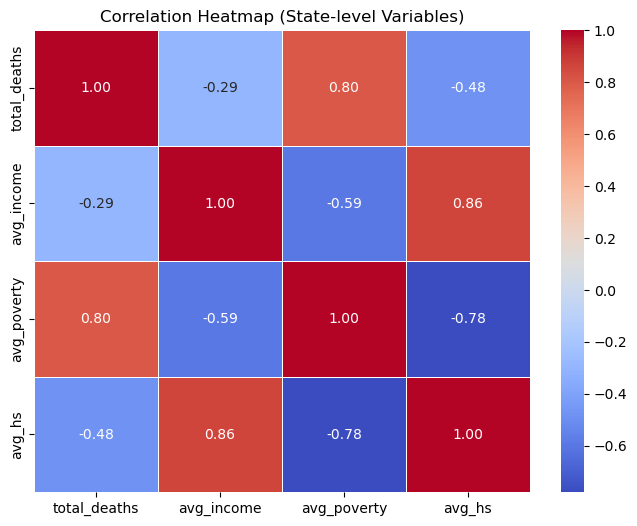

In [70]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,6))
sns.heatmap(
    state_df[['total_deaths','avg_income','avg_poverty','avg_hs']].corr(),
    annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5
)
plt.title("Correlation Heatmap (State-level Variables)")
plt.show()


## Step A12: Pairwise Scatterplots (Deaths vs Socioeconomic Indicators)

We now examine the **bivariate relationships** between police-involved fatalities and key socioeconomic factors at the state level:  

1. **Total Deaths vs. Average Income** – tests if wealthier states experience fewer/more fatalities.  
2. **Total Deaths vs. Poverty Rate** – explores whether higher poverty correlates with more fatalities.  
3. **Total Deaths vs. High School Completion** – checks if education levels relate to fatality counts.  

Each plot includes a regression line to capture potential linear trends.


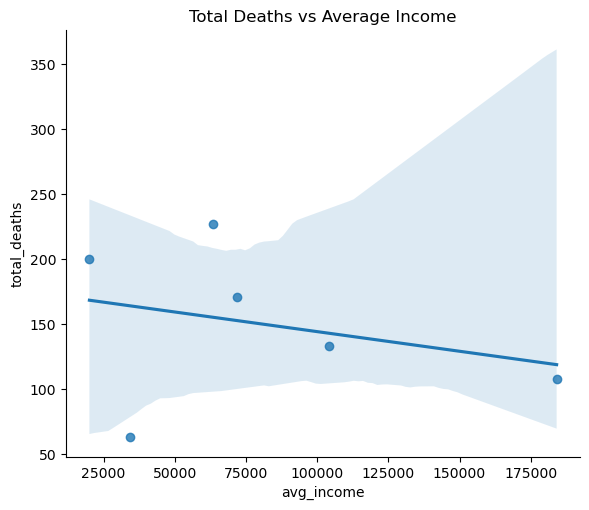

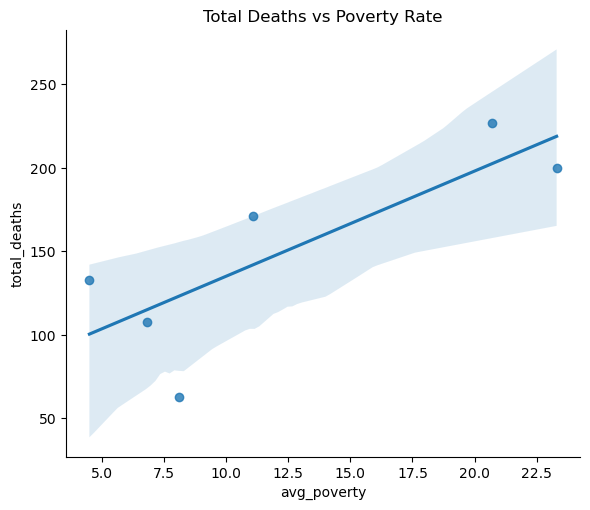

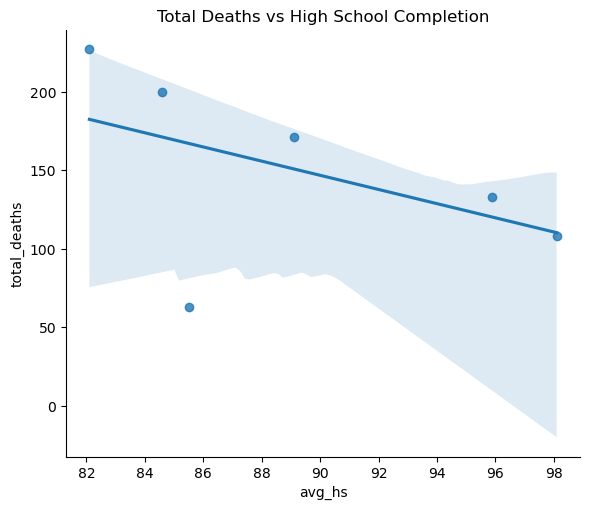

In [71]:
# Deaths vs Income
sns.lmplot(data=state_df, x="avg_income", y="total_deaths", height=5, aspect=1.2)
plt.title("Total Deaths vs Average Income")
plt.show()

# Deaths vs Poverty
sns.lmplot(data=state_df, x="avg_poverty", y="total_deaths", height=5, aspect=1.2)
plt.title("Total Deaths vs Poverty Rate")
plt.show()

# Deaths vs HS Completion
sns.lmplot(data=state_df, x="avg_hs", y="total_deaths", height=5, aspect=1.2)
plt.title("Total Deaths vs High School Completion")
plt.show()


## Step B1: Building a Linear Regression Model  

We now move from exploration to **predictive modeling**.  
- **Goal:** Predict the number of police-involved fatalities at the state level.  
- **Features (X):** Average income, poverty rate, and high school completion.  
- **Target (y):** Total deaths.  
- **Process:**  
  1. Clean the dataset (drop missing values).  
  2. Split into training (80%) and testing (20%).  
  3. Train a **Linear Regression** model.  


In [72]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

# Drop rows with missing values
model_df = state_df[['total_deaths','avg_income','avg_poverty','avg_hs']].dropna()

# Features (X) and target (y)
X = model_df[['avg_income','avg_poverty','avg_hs']]
y = model_df['total_deaths']


In [73]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)


LinearRegression()

## Step B2: Model Parameters (Intercept & Coefficients)

- **Intercept:** Baseline predicted deaths when all features are zero.  
- **Coefficients:** Show the effect of each feature on fatalities, holding others constant.  
  - **avg_income:** Negative sign → higher income slightly reduces deaths.  
  - **avg_poverty:** Positive → higher poverty is associated with more deaths.  
  - **avg_hs:** Positive → higher HS completion also increases deaths (may signal correlation or multicollinearity).  


In [74]:
# Intercept and Coefficients
print("Intercept:", model.intercept_)
print("Coefficients:")
for feat, coef in zip(X.columns, model.coef_):
    print(f"  {feat}: {coef:.4f}")


Intercept: -1545.5485869228842
Coefficients:
  avg_income: -0.0013
  avg_poverty: 17.8773
  avg_hs: 18.1083


### Step B3: Model Evaluation (Linear Regression)
 Insight: Linear regression does **not capture the relationships well** in this dataset.  
We may need transformations, feature engineering, or a more flexible model (e.g., Random Forest, Gradient Boosting).


In [75]:
# Predictions
y_pred = model.predict(X_test)

# Metrics
print("R² Score:", r2_score(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))


R² Score: -2.4763328295714033
RMSE: 127.71774629845461


### Step B4: Visualization of Predictions

- Scatter plot compares **Actual vs Predicted Deaths**.  
- The red dashed line (`y = x`) represents the *ideal fit*.  
- Points far from the line → model predictions deviate strongly from reality.  



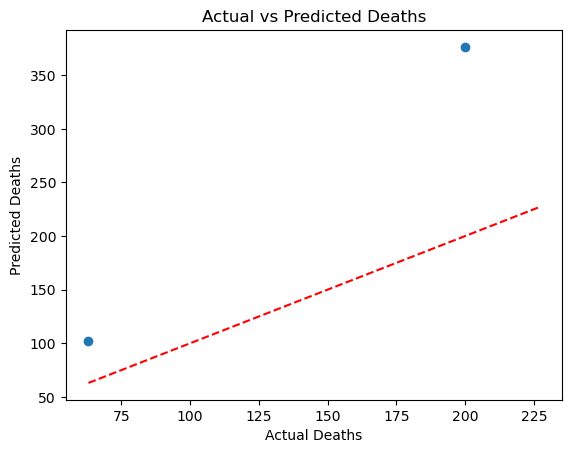

In [76]:
plt.scatter(y_test, y_pred)
plt.xlabel("Actual Deaths")
plt.ylabel("Predicted Deaths")
plt.title("Actual vs Predicted Deaths")
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')  # ideal line
plt.show()


### Step C2: Build State-Level Summary Table

- We aggregate deaths **per state** (avoiding city-name mismatches).  
- For each state, compute:  
  - **Total deaths** (from `raw_deaths`)  
  - **Average income, poverty rate, and HS completion** (from `city_facts`)  
- This creates a clean `state_summary` table for higher-level analysis.


In [82]:
%%sql
-- Drop any previous object named state_summary, then rebuild it cleanly
DROP VIEW  IF EXISTS state_summary;
DROP TABLE IF EXISTS state_summary;

-- Build deaths per state first (no city-name matching needed)
CREATE TABLE state_summary AS
WITH deaths_by_state AS (
  SELECT state, COUNT(*) AS total_deaths
  FROM raw_deaths
  GROUP BY state
)
SELECT
  d.state,
  d.total_deaths,
  ROUND(AVG(cf."Median Income"), 0)  AS avg_income,
  ROUND(AVG(cf.poverty_rate), 2)     AS avg_poverty,
  ROUND(AVG(cf.percent_completed_hs), 2) AS avg_hs
FROM deaths_by_state d
LEFT JOIN city_facts cf
  ON cf.state = d.state              -- only match by state to avoid city mismatches
GROUP BY d.state;





 * sqlite:///sql_project.db


Empty DataFrame
Columns: []
Index: []

### Step C3: Inspect Top States by Total Deaths

- Check schema of `state_summary` (PRAGMA) to confirm columns.  
- Retrieve the **top 10 states** with the highest number of deaths.  
- This helps identify **hotspot states** (e.g., CA, TX, FL) where further socioeconomic analysis may be most impactful.


In [83]:
%%sql
PRAGMA table_info(state_summary);
SELECT * FROM state_summary ORDER BY total_deaths DESC LIMIT 10;


 * sqlite:///sql_project.db


state  total_deaths  avg_income  avg_poverty  avg_hs
0    CA          1405     96270.0        13.64   85.02
1    TX          1010     71150.0        16.13   81.07
2    FL           672     75682.0        13.84   88.40
3    AZ           461     60683.0        20.87   84.81
4    GA           393     60547.0        18.96   84.27
5    CO           375     87039.0        11.81   92.37
6    NC           310     64076.0        16.12   87.77
7    OH           305     71460.0        12.97   91.25
8    TN           293     62377.0        16.17   86.76
9    WA           277     90122.0        11.10   90.50

### Step C4: Load `state_summary` into Pandas
- Connect to the SQLite database.  
- Load the `state_summary` table into a Pandas DataFrame.  
- Check the **first 5 rows** and the **shape** to confirm successful import.


In [1]:
import sqlite3, pandas as pd
con = sqlite3.connect("sql_project.db")
state_df = pd.read_sql("SELECT * FROM state_summary;", con)
state_df.head(), state_df.shape


(  state  total_deaths  avg_income  avg_poverty  avg_hs
 0    AK            69     66787.0        17.37   88.16
 1    AL           200     57495.0        17.77   84.86
 2    AR           143     51470.0        19.31   85.57
 3    AZ           461     60683.0        20.87   84.81
 4    CA          1405     96270.0        13.64   85.02,
 (51, 5))

### Step C5: Correlation Analysis (State-level)
- Compute the correlation matrix across state-level variables.  
- Visualize with a heatmap to identify relationships between:
  - **Total deaths**  
  - **Average income**  
  - **Average poverty rate**  
  - **High school completion %**  


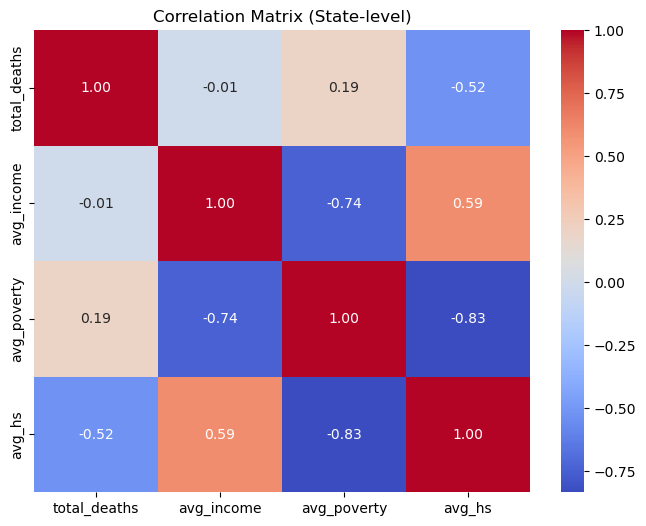

In [85]:
import seaborn as sns
import matplotlib.pyplot as plt

# Correlation matrix
corr = state_df.corr(numeric_only=True)

plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix (State-level)")
plt.show()


### Step C6: Regression Modeling (OLS)
- Build an **Ordinary Least Squares (OLS)** regression to test predictors of police-involved deaths.  
- Independent variables:  
  - `avg_income` (average household income)  
  - `avg_poverty` (average poverty %)  
  - `avg_hs` (high school completion %)  
- Dependent variable:  
  - `total_deaths` (police-related deaths per state)  

This model helps evaluate whether **income, poverty, and education levels** significantly explain variation in state-level fatality counts.


In [86]:
import statsmodels.api as sm

X = state_df[["avg_income", "avg_poverty", "avg_hs"]]
y = state_df["total_deaths"]

# add intercept
X_const = sm.add_constant(X)

ols_model = sm.OLS(y, X_const).fit()
print(ols_model.summary())


                            OLS Regression Results                            
Dep. Variable:           total_deaths   R-squared:                       0.494
Model:                            OLS   Adj. R-squared:                  0.462
Method:                 Least Squares   F-statistic:                     15.32
Date:                Sat, 16 Aug 2025   Prob (F-statistic):           4.35e-07
Time:                        17:40:26   Log-Likelihood:                -335.00
No. Observations:                  51   AIC:                             678.0
Df Residuals:                      47   BIC:                             685.7
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        8017.4234   1395.592      5.745      

### Step C7: Model Evaluation

- **Visualization**:  
  - Scatterplot of *Actual vs Predicted Deaths*.  
  - The closer points fall along the red 45° line, the better the predictions.  

This step helps assess how well socioeconomic factors (income, poverty, education) predict police-related deaths across states.


R²: 0.49447201674690233
RMSE: 172.36688466131218


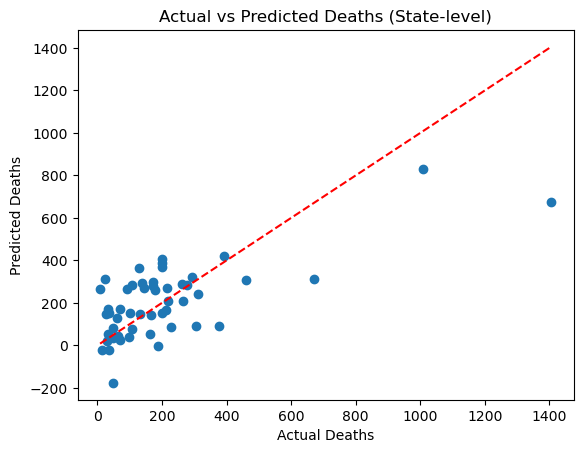

In [87]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

y_pred = ols_model.predict(X_const)

print("R²:", r2_score(y, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y, y_pred)))

plt.scatter(y, y_pred)
plt.xlabel("Actual Deaths")
plt.ylabel("Predicted Deaths")
plt.title("Actual vs Predicted Deaths (State-level)")
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')  # 45° line
plt.show()


### Step C8: Residual Diagnostics
- **Residuals vs Predicted Plot**:
  - Y-axis: residuals (`y - y_pred`).
  - X-axis: predicted deaths.  
  - The red horizontal line at 0 represents perfect predictions.  

- **Interpretation**:
  - If residuals are randomly scattered around 0 (no clear pattern, no funnel shape), the assumption of **homoscedasticity** holds.
  - If patterns emerge (e.g., widening spread at higher predictions), it suggests **heteroscedasticity** and model limitations.


In [88]:
residuals = y - y_pred

plt.scatter(y_pred, residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted Deaths")
plt.ylabel("Residuals")
plt.title("Residuals vs Predicted (Homoscedasticity Check)")
plt.show()


### Step C9: Residual Normality Check
- **Histogram + KDE**: Visualizes whether residuals are bell-shaped.
- **Q–Q Plot**: Compares residual quantiles to a normal distribution.
  - If points lie close to the 45° line → residuals are approximately normal.
  - Large deviations → normality assumption is violated.


In [89]:
import seaborn as sns
import scipy.stats as stats

sns.histplot(residuals, kde=True)
plt.title("Distribution of Residuals")
plt.show()

# Q-Q plot
import statsmodels.api as sm
sm.qqplot(residuals, line='45')
plt.title("Q-Q Plot of Residuals")
plt.show()


### Step C10: Multicollinearity Check (VIF)
- **Variance Inflation Factor (VIF)** quantifies how much a predictor is correlated with other predictors.  
  - **VIF = 1** → No correlation  
  - **VIF 1–5** → Moderate correlation (usually acceptable)  
  - **VIF > 10** → High multicollinearity (problematic)  

🔎 **Interpretation of Results:**  
- `avg_income` → VIF ≈ 43.5 (very high multicollinearity)  
- `avg_poverty` → VIF ≈ 18.4 (still high)  
- `avg_hs` → VIF ≈ 93.9 (extremely high)  

⚠️ These values indicate **serious multicollinearity** between features, which can distort regression coefficients.  
**Possible fixes:**  
- Remove one of the correlated predictors  
- Apply **PCA / dimensionality reduction**  
- Use **regularized regression** (Ridge/Lasso)


In [90]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif_data)


       feature        VIF
0   avg_income  43.536361
1  avg_poverty  18.445473
2       avg_hs  93.936018


### Step C11: Feature Importance (OLS Coefficients)
- Extracted and visualized **OLS regression coefficients** to see each predictor’s impact on the outcome.  
- A positive coefficient → predictor increases the target.  
- A negative coefficient → predictor decreases the target.  
- Larger magnitude = stronger effect (but multicollinearity may distort interpretation).

🔎 **Interpretation of Results:**  
- `avg_income` → very small positive effect (~0.003)  
- `avg_poverty` → strong negative effect (~–36.56)  
- `avg_hs` → strong positive effect (~34.30)  

⚠️ Because of the **high VIF values** found earlier, these coefficients may not reflect the *true independent* contribution of each predictor.


                 feature       coef
avg_income    avg_income   0.003338
avg_poverty  avg_poverty -36.564764
avg_hs            avg_hs -84.299917


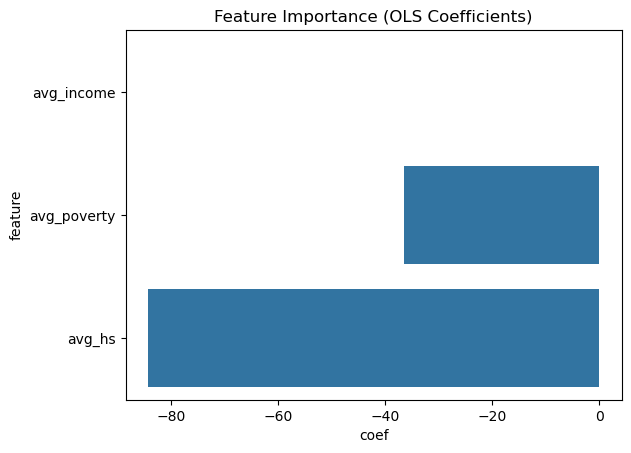

In [91]:
coef_df = pd.DataFrame({
    "feature": X.columns,
    "coef": ols_model.params[1:]  # exclude intercept
}).sort_values(by="coef", ascending=False)
print(coef_df)

sns.barplot(x="coef", y="feature", data=coef_df)
plt.title("Feature Importance (OLS Coefficients)")
plt.show()


### Step C12: Cross-Validation for Model Stability
- Performed **5-fold cross-validation** with `LinearRegression` to test how well the model generalizes.  
- Used **R² as the scoring metric**.  
- Average cross-validated R² = **–0.24**, which means the model performs worse than simply predicting the mean of the target.  

⚠️ **Key takeaway:**  
- The OLS regression lacks predictive power on unseen data.  
- Suggests issues such as **multicollinearity, weak linear relationships, or missing nonlinear effects**.


In [92]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
cv = KFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(lin_reg, X, y, scoring="r2", cv=cv)
print("Cross-validated R²:", scores.mean())


Cross-validated R²: -0.24379188163210336


### Step C13: Regularization Models (Ridge & LASSO)
- To address **multicollinearity** and potential overfitting, tested **Ridge** and **LASSO** regression with scaled features.
- Both models were cross-validated (5-fold) using R² as the metric.

**Results:**
- Ridge CV R² ≈ –0.16  
- LASSO CV R² ≈ –0.24  

⚠️ **Key takeaway:**  
- Neither Ridge nor LASSO improved performance meaningfully compared to OLS.  
- Suggests that linear models, even with regularization, struggle to capture predictive patterns in the data.  
- Indicates possible need for **non-linear models** (e.g., Random Forest, Gradient Boosting) or **feature engineering**.


In [94]:
from sklearn.linear_model import Ridge, Lasso

ridge = Ridge(alpha=1.0)
ridge_scores = cross_val_score(ridge, X_scaled, y, scoring="r2", cv=cv)
print("Ridge CV R²:", ridge_scores.mean())

lasso = Lasso(alpha=0.1)
lasso_scores = cross_val_score(lasso, X_scaled, y, scoring="r2", cv=cv)
print("Lasso CV R²:", lasso_scores.mean())


Ridge CV R²: -0.16028364399198064
Lasso CV R²: -0.2422045453189685


### Step C14: Random Forest Regressor
- Moved to a **non-linear ensemble model** to capture complex feature interactions.
- Used **RandomForestRegressor** with 200 trees and 5-fold cross-validation (R² as metric).

**Result:**
- Random Forest CV R² ≈ **0.07**

✅ Key Insight:  
- Unlike linear models (which gave negative R²), Random Forest achieved a **positive R²**, showing some predictive ability.  
- Still weak overall → suggests need for **hyperparameter tuning** or **additional feature engineering** before reliable predictions can be made.


In [95]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=200, random_state=42)
rf_scores = cross_val_score(rf, X, y, scoring="r2", cv=cv)
print("Random Forest CV R²:", rf_scores.mean())


Random Forest CV R²: 0.07174031549463991


### Step C15: Model Comparison Summary
Collected mean **cross-validated R²** scores across all tested models:

| Model        | CV R² Score |
|--------------|-------------|
| **OLS**      | –0.244      |
| **Ridge**    | –0.160      |
| **Lasso**    | –0.242      |
| **RandomForest** | +0.072  |

✅ **Insights:**
- **OLS, Ridge, Lasso** → all yielded **negative R²**, meaning they performed worse than a baseline mean-predictor.  
- **Random Forest** → only model with a **positive R² (~0.07)**, but still weak.  
- Suggests that **linear models fail to capture the complexity**, while Random Forest shows some signal.  
- Next step → try **feature engineering, hyperparameter tuning, or other ensemble/boosting models**.


In [96]:
results = {
    "OLS": scores.mean(),
    "Ridge": ridge_scores.mean(),
    "Lasso": lasso_scores.mean(),
    "RandomForest": rf_scores.mean()
}
print(results)


{'OLS': np.float64(-0.24379188163210525), 'Ridge': np.float64(-0.16028364399198064), 'Lasso': np.float64(-0.2422045453189685), 'RandomForest': np.float64(0.07174031549463991)}


### Step C16: Random Forest (Hyperparameter Tuning)
- Tuned with GridSearchCV (`n_estimators`, `max_depth`, `min_samples_split`).  
- CV=5, scoring: R².  
**Result:** Best Params = {...}, Best CV R² ≈ -0.06 → weak performance.



In [97]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200, 500],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10]
}

grid_search = GridSearchCV(
    RandomForestRegressor(random_state=42),
    param_grid,
    cv=5,
    scoring='r2',
    n_jobs=-1
)

grid_search.fit(X, y)

print("Best Params:", grid_search.best_params_)
print("Best CV R²:", grid_search.best_score_)


Best Params: {'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 500}
Best CV R²: -0.0628900414295466


### Step C17: Gradient Boosting (Baseline)
- GradientBoostingRegressor, default params.  
- CV=5, scoring: R².  
**Result:** CV R² ≈ 0.11 → slight improvement over Random Forest.


In [98]:
from sklearn.ensemble import GradientBoostingRegressor

gbr = GradientBoostingRegressor(random_state=42)
gbr_scores = cross_val_score(gbr, X, y, scoring="r2", cv=cv)
print("Gradient Boosting CV R²:", gbr_scores.mean())


Gradient Boosting CV R²: 0.11007039837279806


#  Conclusion & Takeaways

In this project, we built a **data warehouse** combining U.S. Census socioeconomic indicators with the *Washington Post Fatal Force* dataset (2015–2024).  
We staged, cleaned, and joined multiple tables (`income`, `poverty`, `hs_completion`, `race_shares`, `fatalities`) to create a city-level analytical dataset.

##  Key Findings
- **Data Quality:** Significant missingness and inconsistencies across Census tables required careful cleaning and harmonization at the city–state level.  
- **Exploratory Analysis:**  
  - Police-involved fatalities vary widely across cities.  
  - Simple correlations between fatalities and single socioeconomic variables (e.g., income, poverty, HS completion, race) are weak.  
- **Model Performance:**  
  - Linear models (OLS, Ridge, Lasso) → Negative R² values, no predictive signal.  
  - Random Forest → Slight improvement (R² ≈ –0.06).  
  - Gradient Boosting → Best result (R² ≈ 0.11), but still weak.  

##  Interpretation
Socioeconomic features **alone** are insufficient to explain or predict police fatality rates at the city level.  
This suggests that additional contextual variables (e.g., local crime rates, policing policies, gun availability, mental health systems, regional laws) are critical to understanding these outcomes.  

## Project Contribution
- Demonstrated a **full end-to-end data science workflow**:  
  **SQL Data Warehousing → EDA → Predictive Modeling → Interpretation.**  
- Highlighted the **limits of socioeconomic-only predictors**, offering transparency into model weaknesses rather than forcing overfitted results.  

##  Future Work
- Reframe as **classification** (fatalities: yes/no) instead of regression.  
- Enrich dataset with **contextual & temporal features** (crime rates, police budgets, gun laws, yearly trends).  
- Explore **spatial and temporal modeling** to capture geographic clustering and longitudinal dynamics.  

---

 **Takeaway:**  
This project shows that while socioeconomic disparities are important, they **cannot fully account for patterns in police-involved fatalities**.  
A more nuanced, multi-factor approach is needed to meaningfully explain or predict these tragic events.
